In [50]:
## Packages -----
cran_packages <- list(
    "Rcpp",
    "data.table",
    "microbenchmark",
    "ggplot2",
    "ggiraph"
)
invisible(
    lapply(
        cran_packages,
        function(i) {
            if (!require(i, character.only = T)) {
                install.packages(i)
                library(i, character.only = T)
            } else {
                library(i, character.only = T)
            }
        }
    )
)
# Package containing a set of helper functions:
if (!require(fromScratchR)) {
    devtools::install_github("pat-alt/fromScratchR")
    library(fromScratchR)
} else {
    library(fromScratchR)
}
theme_set(theme_bw())

# Multilevel regression

*Group members:*
- Elio Abi Karam
- Marc Agustí
- Patrick Altmeyer
- Simon Neumeyer

## Model and synthetic data

We consider a multilevel regression model with group level predictors (varying intercepts) as in Gelman, Hill (2007). For the first level we have for individual $i\in[1,N]$:

$$
\begin{aligned}
&& y_i &= z_{j[i]} + \mathbf{X}_i^T \beta + \varepsilon_i, && \varepsilon_i \sim \mathcal{N}(0, \phi)
\end{aligned}
$$

where $\mathbf{X}_i$ is a $(K \times 1)$ vector of individual-level predictors. Consequently we have that 

$$
\begin{aligned}
&& y_i|z_j[i], \mathbf{X}_i &\sim \mathcal{N}(z_{j[i]} + \mathbf{X}_i^T \beta, \phi)
\end{aligned}
$$

where $\phi^{-1}$ can be thought of as the precision of the data. 

For the second level we have for group $j\in[1,M]$

$$
\begin{aligned}
&& z_j &= \mathbf{u}_j^T \gamma + \eta_j, && \eta_j \sim \mathcal{N}(0, \psi)
\end{aligned}
$$

where $z_j$ are unobserved and $\mathbf{u}_j$ is $(L \times 1)$ vector of observed group-level predictors.

Consequently we have that 

$$
\begin{aligned}
&& z_j|\mathbf{u}_j&\sim \mathcal{N}(\mathbf{u}_j^T \gamma, \psi)
\end{aligned}
$$

where $\psi^{-1}$ can be thought of as the precision of the latent factors. To simulate data from this model we can use the helper function below. For now we will look at a single set of default parameter choices. Note that the choices for `phi` and `psi` roughly imply that the latent, group-level information is twice as precise as the individual level data. We would therefore expect the algorithm to produce final posterior densities of the latent variables that are are more similar to their estimated prior density then the likelihood of the observed data given the latent variables. 

In [101]:
syn_multi_level_reg <- function(
  N=10000,
  M=1000,
  beta=c(1,0.1),
  phi=0.1,
  a=1,
  b=0.5,
  psi=0.05,
  seed=123
) {
  set.seed(seed)
  # 1.) Latent factors: ----
  u <- matrix(rnorm(M))
  z <- a + b * u + rnorm(n=nrow(u),sd=sqrt(psi))
  # Group lengths:
  wgts <- runif(M)
  wgts <- wgts/sum(wgts)
  n_j <- pmax(round(wgts * N),1)
  to_allocate <- N - sum(n_j)
  while (to_allocate!=0) {
    if (to_allocate > 0) {
      idx <- which.min(n_j)
      n_j[idx] <- n_j[idx] + 1
      to_allocate <- to_allocate - 1
    } else {
      idx <- which.max(n_j)
      n_j[idx] <- n_j[idx] - 1
      to_allocate <- to_allocate + 1
    }
  }
  Z <- rep(0, N)
  from <- 1
  for (j in 1:M) {
    idx <- from:(from+n_j[j]-1)
    Z[idx] <- z[j]
    from <- from + n_j[j]
  }
  # 2.) Output: ----
  K <- length(beta)
  X <- matrix(rnorm(N*K), nrow=N)
  y <- Z + X %*% beta + rnorm(n=nrow(X),sd=sqrt(phi))
  model <- list(
    data = list(
      X = X,
      y = y,
      u = u,
      n_j = n_j
    ),
    z = z,
    M = M,
    N = N,
    params = list(
      beta = beta,
      phi = phi,
      psi = psi,
      a = a,
      b = b
    )
  )
  return(model)
}

syn_data <- syn_multi_level_reg()

## EM algorithm

We will use the EM algorithm the uncover the latent factors and fit the multilevel regression model. To do so we first need to derive the *expected* complete data log-likelihood (CLL):

$$
\begin{aligned}
&& Q(\theta, \theta_{t-1}) &= \mathbb{E}_{p(\mathbf{z}|\mathbf{y}, \mathbf{X}, \theta_{t-1})} \left[ \log \ell (\theta | \mathbf{y}, \mathbf{X}, \mathbf{z}) \right]
\end{aligned}
$$

Below we provide a high-level overview of the involved mathematics. Derivations can be found in the appendix if necessary.

### E-step

Generally it can be difficult to compute the expected CLL, but here it is fairly straight-forward to compute the intergral over $\mathbf{z}$ since the posterior density $p(\mathbf{z}|\mathbf{y}, \mathbf{X}, \theta_{t-1})$ is mathematically tractable due to conjugacy. Specifically we have for the posterior density

$$
\begin{aligned}
&& z_j|\mathbf{y}_j,\mathbf{X}_j, \theta&\sim \mathcal{N}(\mu_j, v_j) \\
&& v_j &= \frac{1}{\frac{n_j}{\phi}+\frac{1}{\psi}} \\
&& \mu_j &= \frac{\frac{n_j}{\phi} (\bar{\mathbf{y}}_j - \bar{\mathbf{X}}_j \beta)}{\frac{n_j}{\phi}+\frac{1}{\psi}} + \frac{\frac{1}{\psi} (\mathbf{u}^T_j \gamma)}{\frac{n_j}{\phi}+\frac{1}{\psi}} \\
\end{aligned}
$$

and hence for the expected CLL

$$
\begin{aligned}
&& Q(\theta, \theta_{t-1})&= - {1\over{2}} \left( 
N \log 2\pi\phi + 
{1\over{\phi}} 
\left( 
(\mathbf{y} - \mathbf{X} \beta)^T (\mathbf{y} - \mathbf{X} \beta) - 2(\mathbf{y} - \mathbf{X} \beta)^T \mu_N + \mathbf{1}^T_N (\mu_N^2+\mathbf{v}_N) 
\right) 
\\ + M \log 2\pi\psi +
\left( 
(\mathbf{u} \gamma)^T (\mathbf{u} \gamma) - 2(\mathbf{u} \gamma)^T\mu_M + \mathbf{1}^T_M (\mu_M^2+\mathbf{v}_M) 
\right) 
\right)\\
\end{aligned}
$$

where $\mu_M,\mathbf{v}_M$ are $(M\times 1)$ vectors of posterior means and variances, respectively, and $\mu_M,\mathbf{v}_M$ are their corresponding stacked versions with elements $\mu_j, v_j$ repeated $n_j$ times. As discussed briefly in class, the results for $\mu_j,v_j$ are intuitive, something which we shall explore further below.

### M-step

Since $Q(\theta, \theta_{t-1})$ is just a quadratic form, we can maximise the expected CLL through analytical solutions to the first-order condition $\nabla_{\theta}Q(\theta, \theta_{t-1}) = \mathbf{0}$. It is straight-forward to show that

$$
\begin{aligned}
&& \beta^{\text{MLE}}&= (\mathbf{X}^T\mathbf{X})^{-1} (\mathbf{X}^T \mathbf{y} - \mathbf{X}^T \mu_N) \\
&& \phi^{\text{MLE}}&= {1\over{N}} \left( (\mathbf{y} - \mathbf{X} \beta^{\text{MLE}})^T (\mathbf{y} - \mathbf{X} \beta^{\text{MLE}}) - 2(\mathbf{y} - \mathbf{X} \beta^{\text{MLE}})^T \mu_N + \mathbf{1}^T_N (\mu_N^2+\mathbf{v}_N) \right) \\
&& \gamma^{\text{MLE}}&= (\mathbf{u}^T\mathbf{u})^{-1} \mathbf{u}^T \mu_M\\
&& \psi^{\text{MLE}}&= {1\over{M}} \left( (\mathbf{u} \gamma^{\text{MLE}})^T (\mathbf{u} \gamma^{\text{MLE}}) - 2(\mathbf{u} \gamma^{\text{MLE}})^T\mu_M + \mathbf{1}^T_M (\mu_M^2+\mathbf{v}_M)  \right) \\
\end{aligned}
$$

### Code

We shall now go through how the estimation of the multilevel regression model through EM can be programmed in R. As a first step we use a simple helper function that sets up the model: `multilevel_model` takes as inputs the $(N \times K)$ matrix of inidividual-level predictors `X`, the $(N \times 1)$ output vector `y`, the $(M \times L)$ matrix of group-level predictors `u` and an $(M \times 1)$ vector `n_j` that indicates group sizes. It returns a an object of class `multilevel_model`. (Using a class is not strictly necessary but will turn out to be convenient later as we shall see.)

In [5]:
multilevel_model <- function(
  X,
  y,
  u,
  n_j
) {
  # Group index:
  group <- rep.int(1:nrow(u), times=n_j)
  u <- matrix(rep.int(u, times=n_j))
  U <- cbind(1, unique(u))
  model <- list(
    X=X,
    y=y,
    u=u,
    U=U,
    group=group,
    n_j=n_j
  )
  class(model) <- "multilevel_model"
  return(model)
}
# Prepare model:
model <- multilevel_model(syn_data$data$X, syn_data$data$y, syn_data$data$u, syn_data$data$n_j)

With the model set up we can introduce the main `em` method that fits the model. If no initial guesses for the parameter vector $\theta$ are supplied, the algorithm will take random intial guesses excpet for $\beta_0$ which is set to the pooled OLS estimate without a constant term. The algorithm then iteratively performs the E-step and M-step until convergence. The method finally returns an object of class `em_output` (again not strictly necessary but convenient).

In [80]:
## --------------------- EM algorithm: --------------------- ##
em.multilevel_model <- function(
  model,
  theta0=NULL,
  tol=1e-9,
  print_progress=T,
  max_iter=100
) {
  # Initialization: ----
  if (is.null(theta0)) {
    theta0 <- list(
      beta = qr.solve(model$X, model$y), # initialize as pooled OLS
      phi = runif(1, 0, 100),
      gamma = matrix(rnorm(2)),
      psi = runif(1, 0, 100)
    )
  }
  converged <- FALSE # initialize convergence condition as false
  iter_count <- 1
  # Recursion: ----
  while (!converged & iter_count <= max_iter) {
    if (print_progress) {
      print(iter_count)
    }
    # 1.) E-step: ----
    posterior_moments <- posterior(model, theta0) # returns and (M x 1) vectors of posteriors
    Q0 <- Q(model, theta0, posterior_moments) # to compare below
    # 2.) M-step: ----
    theta <- update_theta(model, theta0, posterior_moments)
    # Recalculate given MAP parameter estimates:
    Q1 <- Q(model, theta, posterior_moments)
    # Check for convergence:
    if (print_progress) {
      print(sprintf("Improvement of %0.2f",Q1-Q0))
    }
    converged <- Q1-Q0 < tol
    theta0 <- theta # new theta 0
    iter_count <- iter_count + 1
  }
  # Allocate and return output:
  output <- list(
    model = model,
    coefficients = theta,
    n_iter = iter_count - 1,
    converged = converged
  )
  class(output) <- "em_output"
  return(output)
}

em <- function(
  model,
  theta0=NULL,
  tol=1e-9,
  print_progress=T,
  max_iter=100
) {
  UseMethod("em")
}

You will note that this function depends on a few helper functions: `posterior` - returns the first two moments of the posterior density of the latent variable -, `update_theta` - updates parameters according to the first-order conditions - and finally `Q` which compute the expected CLL for a given $\theta$ and posterior moments. 
These functions are methods that relate to the `multilevel_model` class we introdcued above, since they depend on the distribution we assume for the data and latent variables. Setting the code up this way is convenient since according to our assumption we can alter these methods and use the `em` method independently in the same way as before. Before running the `em` method we need to source the methods we just introduced.

##### `posterior`

In [11]:
posterior.multilevel_model <- function(
  model,
  theta
) {
  n_j <- model$n_j
  list2env(theta, envir = environment())
  # Posterior density ----
  var_posterior <- function(phi, psi, n_j) {
    v <- (n_j*phi^(-1) + psi^(-1))^(-1)
    return(v)
  }
  # Posterior mean ----
  mean_posterior <- function(phi, psi, n_j, v, mu_a, mu_b) {
    v * n_j * phi^(-1) * (mu_a) +
      v * psi^(-1) * (mu_b)
  }
  # Compute density ----
  p <- t(
    sapply(
      1:length(n_j),
      function(j) {
        y <- matrix(model$y[model$group==j])
        X <- matrix(model$X[model$group==j,], ncol = ncol(model$X))
        U <- matrix(model$U[j,], ncol = ncol(model$U))
        if (nrow(X) > 1) {
          mu_a <- mean(y) - colMeans(X) %*% beta
        } else {
          mu_a <- mean(y) - X %*% beta
        }
        mu_b <- unique(U) %*% gamma
        # Variance:
        v <- var_posterior(phi, psi, n_j[j])
        # Mean:
        mu <- mean_posterior(phi, psi, n_j[j], v, mu_a, mu_b)
        # Density:
        return(c(v=v, mu=mu))
      }
    )
  )
  return(p)
}

posterior <- function(model, theta) {
  UseMethod("posterior")
}

##### `update_theta`

In [12]:
update_theta.multilevel_model <- function(model, theta, p) {
  # Gather:
  n_j <- model$n_j
  list2env(theta, envir = environment())
  X <- model$X
  y <- model$y
  N <- nrow(y)
  M <- length(n_j)
  U <- model$U
  # Posterior moments:
  mu_M <- matrix(p[,"mu"])
  v_M <- matrix(p[,"v"])
  mu_N <- matrix(rep.int(mu_M, times=n_j))
  v_N <- matrix(rep.int(v_M, times=n_j))
  # beta: ----
  beta_map <- qr.solve(crossprod(X), (crossprod(X,y) - crossprod(X, mu_N)))
  theta$beta <- beta_map # update
  # phi: ----
  phi_map <- (1/N) *
    (crossprod(y-X%*%beta_map) - 2 * crossprod(y - X %*% beta_map, mu_N) + sum( mu_N^2 + v_N ))
  theta$phi <- phi_map # update phi
  # gamma: ----
  gamma_map <- qr.solve(crossprod(U), crossprod(U,mu_M))
  theta$gamma <- gamma_map # update gamma
  # psi: ----
  psi_map <- (1/M) *
    (crossprod(U %*% gamma_map) + sum( mu_M^2 + v_M ) - 2 * crossprod(U %*% gamma_map, mu_M))
  theta$psi <- psi_map # update psi
  return(theta)
}

update_theta <- function(model, theta, p) {
  UseMethod("update_theta")
}

##### `Q`

In [13]:
Q.multilevel_model <- function(model, theta, p) {
  n_j <- model$n_j
  list2env(theta, envir = environment())
  y <- model$y
  X <- model$X
  U <- model$U
  N <- nrow(y)
  M <- length(n_j)
  # Posterior moments:
  mu_M <- matrix(p[,"mu"])
  v_M <- matrix(p[,"v"])
  mu_N <- matrix(rep.int(mu_M, times=n_j))
  v_N <- matrix(rep.int(v_M, times=n_j))
  # Compute:
  A <- N * log(2*pi*phi)
  B <- phi^(-1) * ( crossprod(y - X %*% beta) - 2 * crossprod(y - X %*% beta, mu_N) + sum( mu_N^2 + v_N ) )
  C <- M * log(2*pi*psi)
  D <- psi^(-1) * ( crossprod(U %*% gamma) + sum( mu_M^2 + v_M ) - 2 * crossprod(U %*% gamma, mu_M))
  value <- (-1/2) * ( A + B + C + D )
  return(value)
}

Q <- function(model, theta, p) {
  UseMethod("Q")
}

In fact there is one further method relating to the `multilevel_model` which is used under the hood to infer the latent variables given our final estimate of $\theta$. The `infer_latent` method is not used anywhere inside the `em` method since the algorithm that fits the model need not know the estimated values of the latent factors at any point - it depends solely on estimates of their posterior moments. But estimated latent variables will be important in order to predict from the fitted model among other things, so we introduce the method that infers them here:

In [17]:
infer_latent.multilevel_model <- function(model, theta) {
  n_j <- model$n_j
  list2env(theta, envir = environment())
  z <- model$U %*% gamma
  return(z)
}

infer_latent <- function(model, theta) {
  UseMethod("infer_latent")
}

Finally let us briefly introduce a couple of standard methods relating the model output - i.e. the `em_output` object returned by the `em` method. We will leave these uncommented as they perform standard procedures.

In [21]:
## --------------------- Standard methods: --------------------- ##
predict.em_output <- function(em_output) {
  # Predictors: ----
  X <- em_output$model$X
  beta <- em_output$coefficients$beta
  # Latent variable estimates: ----
  Z_M <- infer_latent(em_output$model, em_output$coefficients)
  n_j <- em_output$model$n_j
  Z_N <- rep.int(Z_M, n_j)
  # Fit: ----
  fitted <- Z_N + X %*% beta
  return(fitted)
}

predict <- function(em_output) {
  UseMethod("predict")
}

residuals.em_output <- function(em_output) {
  y <- em_output$model$y
  fitted <- predict(em_output)
  res <- y - fitted
  return(res)
}

residuals <- function(em_output) {
  UseMethod("residuals")
}

coefficients.em_output <- function(em_output) {
  beta <- em_output$coefficients$beta
  if (!is.null(colnames(em_output$model$X))) {
    beta_names <- colnames(em_output$model$X)
  } else {
    beta_names <- sprintf("X_%i", 1:length(beta))
  }
  Z_M <- infer_latent(em_output$model, em_output$coefficients)
  Z_M_names <- sprintf("z_%i", 1:nrow(Z_M))
  coeffs <- data.table::data.table(
    Covariate = c(beta_names, Z_M_names),
    Coefficient = c(beta, Z_M)
  )
  return(coeffs)
}

coefficients <- function(em_output) {
  UseMethod("coefficients")
}

rsquared.em_output <- function(em_output) {
  y <- em_output$model$y
  fitted <- predict(em_output)
  rss <- sum((fitted - y)^2)
  tss <- sum((y-mean(y))^2)
  rsq <- 1 - rss/tss
  return(rsq)
}

rsquared <- function(em_output) {
  UseMethod("rsquared")
}

print.em_output <- function(em_output) {
  cat("Coefficient estimates: -----\n")
  print(coefficients(em_output))
  cat("Precision estimates: -----\n")
  cat(sprintf("Data: %0.2f\n",(em_output$coefficients$phi)^(-1)))
  cat(sprintf("Latent: %0.2f\n",(em_output$coefficients$psi)^(-1)))
  cat(sprintf("R-squared: %0.2f\n", rsquared(em_output)))
  cat("Performance: -----\n")
  cat(sprintf("Number of iterations: %0.2f\n", em_output$n_iter))
}

### First run

Finally, let us a perform a first run of our model. With the synthetic data and the corresponding `multilevel_model` already prepared we can simply run the following:

In [32]:
em_output <- em(model, print_progress = F)
em_output

Coefficient estimates: -----
      Covariate Coefficient
   1:       X_1  1.00604683
   2:       X_2  0.09589592
   3:       z_1  0.71802461
   4:       z_2  0.88875274
   5:       z_3  1.81341163
  ---                      
 998:     z_996  0.96122204
 999:     z_997  1.56106945
1000:     z_998  0.30935784
1001:     z_999  0.73759356
1002:    z_1000  0.87892499
Precision estimates: -----
Data: 9.96
Latent: 19.76
R-squared: 0.90
Performance: -----
Number of iterations: 15.00

As per the output, the algorithm converged after only a few iterations. It attributes a precision to the group-level information roughly twice as high as the individual-level data, which was expected given the default parameter choices from above. The estimated $R^2$ coefficient of determination is 0.90. This is close to the true $R^2$ of the model as computed below:

In [41]:
.rsquared <- function(y,fitted) {
  rss <- sum((fitted - y)^2)
  tss <- sum((y-mean(y))^2)
  rsq <- 1 - rss/tss
  return(rsq)
}
Z_N <- matrix(rep.int(syn_data$z, model$n_j))
y_model_true <- Z_N + model$X %*% em_output$coefficients$beta
cat(sprintf("True model: %0.2f", .rsquared(model$y, y_model_true)))

True model: 0.93

Let us also briefly compare the $R^2$ obtained through the EM estimation to what would have been obtained if we had simply run pooled OLS, so neglecting group-level information altogether:

In [42]:
y_hat_pooled <- qr.fitted(qr.default(cbind(1,model$X)), model$y)
cat(sprintf("Pooled OLS: %0.2f", .rsquared(model$y, y_hat_pooled)))

Pooled OLS: 0.71

Evidently (and not surprisingly) including group-level information improves the model's predictive accuracy. What about simply running panel regression with group-level fixed effects? This could be done as follows in R:

In [43]:
Z_ind <- matrix(0, nrow=nrow(model$y), ncol=length(model$n_j))
from <- 1
for (j in 1:ncol(Z_ind)) {
    idx <- from:(from+model$n_j[j]-1)
    Z_ind[idx, j] <- 1
    from <- from + model$n_j[j]
}
y_hat_fe <- qr.fitted(qr.default(cbind(Z_ind,model$X)), model$y)
cat(sprintf("Panel FE: %0.2f", .rsquared(model$y, y_hat_fe)))

Panel FE: 0.94

This produces a higher $R^2$ than the true model $R^2$, but note that this single-level regression is of high dimensionality and consequently estimates are noisy (recall the *bias-variance trade-off*). For similar results and discussion see Chapter 16 in Gelman, Hill (2007).

## Numerical tests

In this section we will briefly explore how our algorithm performs through numerical exercises. We will keep this quite short and instead spend more time on the following, more interesting section on Bayesian inference.

#### Varying precision

In the first numerical test we will vary the values of $\phi$ and $\psi$ - that is we will play with the precision of the data and latent variables. To keep computational time limited we will impose a maximum number of iterations on the EM algorithm.

In [89]:
grid_search <- data.table(
  expand.grid(
    phi = c(0.01, 0.5, 1),
    psi = c(0.01, 0.5, 1)
  )
)
vary_precision <- rbindlist(
  lapply(
    1:nrow(grid_search),
    function(i) {
      phi <- grid_search[i,phi]
      psi <- grid_search[i,psi]
      syn <- syn_multi_level_reg(phi = phi, psi = psi)
      mod <- multilevel_model(syn$data$X, syn$data$y, syn$data$u, syn$data$n_j)
      em_output <- em(mod, max_iter = 20, print_progress = F)
      output <- data.table(
        phi = phi,
        psi = psi,
        converged = c(em_output$converged),
        n_iter = em_output$n_iter,
        rsq = rsquared(em_output),
        cor_z = as.numeric(cor(syn$z, infer_latent(em_output$model, em_output$coefficients)))
      )
      return(output)
    }
  )
)

The table below shows the results of our numerical exercises. A first observations is that unsurprisingly the coefficient of determination $R^2$ (column `rsq`) decreases with the magnitude of the noise parameters. Reassuringly we also find that the algorithm generally converges after only a few iterations, which is likely due to the simplicity of the data generating processes. Convergence is not reached after the imposed number of maximum iterations only in two cases. In particular, these cases correspond to situations where the precision around the latent variables is high compared to the precision of individual-level data. A possible intuition here may be that the EM algorithm struggles to converge because at the inference stage the prior beliefs about the distribution of the latent factors always heavily dominates the likelihood and hence it only very gradually learns from the inidividual-level data. Related ideas are discussed in more detail below.

Finally, we make one observation regarding the inferred latent variables (even though this topic will get much more attention in the following sections). Column `cor_z` shows the correlation between the inferred latent variables and their corresponding actual values. Unsurprisingly, this correlation increases as uncertainty around the group-level information decreases (more on this below).

In [90]:
vary_precision

phi,psi,converged,n_iter,rsq,cor_z
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
0.01,0.01,TRUE,11,0.9845750,0.9807026
0.50,0.01,FALSE,20,0.7179139,0.9807026
1.00,0.01,FALSE,20,0.5636524,0.9807026
0.01,0.50,TRUE,10,0.7271636,0.6169538
0.50,0.50,TRUE,10,0.5772948,0.6169538
1.00,0.50,TRUE,14,0.4778779,0.6169538
0.01,1.00,TRUE,11,0.5808384,0.5015549
0.50,1.00,TRUE,9,0.4835794,0.5015549
1.00,1.00,TRUE,9,0.4135778,0.5015549


#### Varying sample size

In our second numerical exercise we play with the sample sizes both at individual and group level. Once again we keep a lid on computational time by imposing a maximum number of iterations.

In [103]:
grid_search <- data.table(
  expand.grid(
    N = c(200, 2000, 20000),
    M = c(10, 100, 1000)
  )
)
grid_search <- grid_search[N>M]
vary_size <- rbindlist(
  lapply(
    1:nrow(grid_search),
    function(i) {
      N <- grid_search[i,N]
      M <- grid_search[i,M]
      syn <- syn_multi_level_reg(N=N, M=M)
      mod <- multilevel_model(syn$data$X, syn$data$y, syn$data$u, syn$data$n_j)
      em_output <- em(mod, max_iter = 20, print_progress = F)
      output <- data.table(
        N = N,
        M = M,
        converged = c(em_output$converged),
        n_iter = em_output$n_iter,
        rsq = rsquared(em_output),
        cor_z = as.numeric(cor(syn$z, infer_latent(em_output$model, em_output$coefficients)))
      )
      return(output)
    }
  )
)

The results are shown below. In this case we cannot make out any obvious pattern with respect the the `rsq` and `cor_z` columns. An interesting finding is that the number of iterations needed for convergence decreases with the ratio of the first- and second-level sample size $N\over{M}$. The intuition may once again be that in these case prior beliefs take a very dominant role and prevent learning from individual-level data (but this is just a hunch and may very well be incorrect).

In [104]:
vary_size

N,M,converged,n_iter,rsq,cor_z
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
200,10,TRUE,16,0.9129197,0.9551212
2000,10,TRUE,6,0.9144289,0.9551212
20000,10,TRUE,5,0.9120222,0.9551212
200,100,FALSE,20,0.8860174,0.8999223
2000,100,TRUE,14,0.8953193,0.8999223
20000,100,TRUE,9,0.8951782,0.8999223
2000,1000,FALSE,20,0.8954325,0.9165168
20000,1000,TRUE,17,0.8952455,0.9165168


## Bayesian Inference

In this section we will turn to the most interesting topic - Bayesian Inference for the latent variables. In particular, we want to investigate how the model behaves when we vary $\phi$ and $\psi$. We already hinted above that depending on their relative magnitude we would expect different outcomes for the final estimates of the latent variables. This all boils down to Bayes Theorem - specifically in our context

$$
\begin{aligned}
&& p(\mathbf{z}|\mathbf{y}, \mathbf{X}, \theta) & \propto p(\mathbf{y}, |\mathbf{z},\mathbf{X},\theta) p(\mathbf{z}|\theta) = \ell(\mathbf{z}|\theta) p(\mathbf{z}|\theta)
\end{aligned}
$$

where $\ell(\mathbf{z}|\theta)$ is the likelihood of the observed data for different values of $\mathbf{z}$ and $p(\mathbf{z}|\theta)$ corresponds to the density of $\mathbf{z}$ prior to observing the data. Since the posterior density is proportional to the product of a likelihood depending on $\phi$ and a prior depending on $\psi$, we should expect our estimated posterior density to look more like the prior density if $\phi^{-1} < \psi^{-1}$. Informally speaking we would expect the our latent variables estimates to be closer to their "true" values if uncertainty around the "true" values is low. Conversely, the poster density of $\mathbf{z}$ will generally be closer in shape to the likelihood of the data, if the data is precise (small $\phi$). 

In particular - and in fact irrespective of our choices of $\phi,\psi$ - at group level we would expect the distribution of $z_j$ to be driven more significantly by the data whenever $n_j$ is large, i.e. we have a lot of data. We have already seen above the formulas corresponding to the posterior moments, which are consistent with this intuitive observation. 

Staying for a moment with the single model output from the previous section, let us see if the output generated by our EM algorithm is in fact in line with the expected relationships we just introduced. Firstly, let us have a look at how the estimated latent variables relate to their actual, synthetic values. As seen above the latent variable estimate are easily recovered from the model through the `infer_latent` method. Since our default choice of $\psi$ is fairly low (relative to the default group-level model average $\mathbf{u}\gamma$) we would expect a strong relationship between predictions and actual values. In fact, as the plot below shows for 25 randomly selected groups, the output of our algorithm is consistent with this expectations.

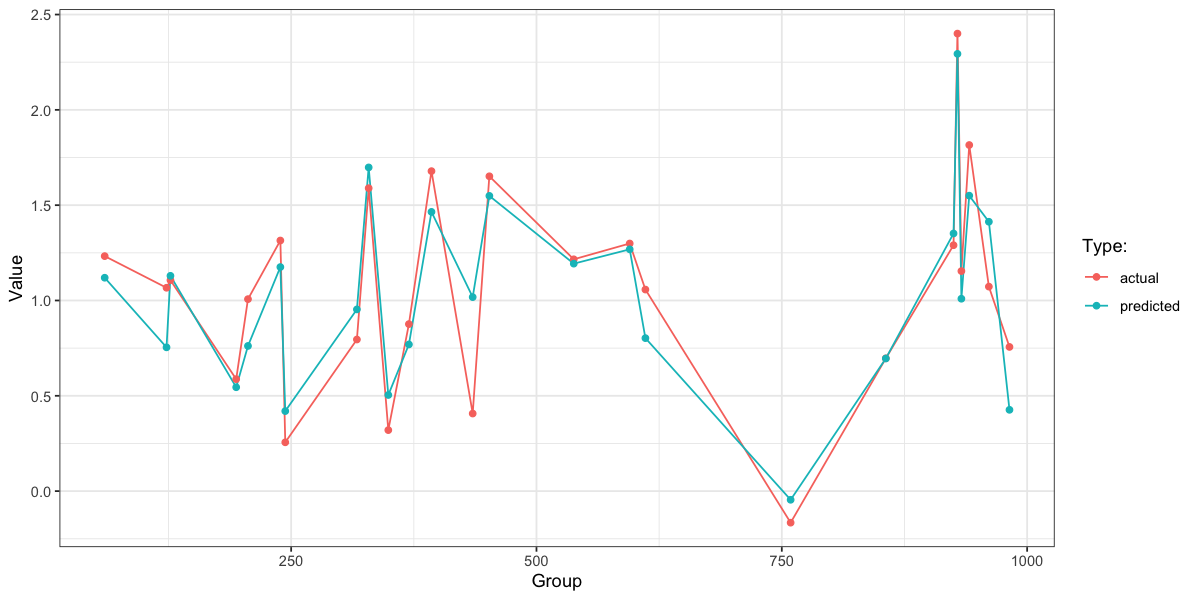

In [105]:
options(repr.plot.width = 10, repr.plot.height = 5)
actual <- syn_data$z
predicted <- infer_latent(model, theta=em_output$coefficients)
dt_plot <- data.table(actual = c(actual), predicted = c(predicted), n_j=model$n_j)
dt_plot[,group:=1:.N]
dt_plot <- melt(dt_plot, measure.vars = c("actual", "predicted"))
ggplot(
  data=dt_plot[group %in% sample(1:max(group),size=25)], 
  aes(x=group, y=value, colour=variable)
) +
  geom_line() +
  geom_point() +
  scale_colour_discrete(name="Type:") +
  labs( 
    x="Group",
    y="Value"
  ) 

In practice actual values of the latent variable are of course unobserved, so the chart above cannot be produced. Still, we can do something else even more interesting and illustrative of Bayes Theorem. Using the final parameter estimates $\hat\theta$ produced by our algorithm we can plot the estimated prior distribution, likelihood and posterior distribution directly. To do this we proceed as follows:

1. For the prior and posterior densities retrieve estimates of the two moments describing their respective Gaussian distributions. Then simply draw $n$ random samples of $z_j^*$ from these distributions and plot the resulting densities. 

2. For the likelihood we need to proceed backwards. Since $\ell(z_j|\theta)$ is a function of $z_j$ we need to supply values $z_j^*$ to obtain the corresponding likelihood.

Now let us see how we can implement this in R. We have already introduced the `posterior` method above. Similarly we can use the `prior` method below to comute prior moments.

In [64]:
prior.multilevel_model <- function(
  model,
  theta
) {
  prior_mean <- model$U %*% theta$gamma
  p <- cbind.data.frame(v=theta$psi, mu=prior_mean)
  return(p)
}

prior <- function(model, theta) {
  UseMethod("prior")
}

The `likelihood` method takes a single value `z` and computes its corresponding likelihood. It will be run many times for values inside the range of latent variable samples returned from the `prior` and `posterior` methods.

In [65]:
likelihood.multilevel_model <- function(
  model,
  theta,
  z,
  j
) {
  list2env(theta, envir = environment())
  y <- matrix(model$y[model$group==j])
  X <- matrix(model$X[model$group==j,], ncol = ncol(model$X))
  n_j <- model$n_j[j]
  ll <- (2*pi*phi)^(-n_j/phi) *
    exp( -(2*phi)^(-1) * crossprod(y-z-X %*% beta) )
  return(ll)
}

likelihood <- function(model, theta, z, j ) {
  UseMethod("likelihood")
}

Finally, we bring it all together in a simple wrapper function `plot_posterior`. If no specific group(s) are supplied the method will by default choose random groups with group size $n_j$ corresponding to one of the quintiles of all group sizes. This way we should be able to illustrate nicely the effect of $n_j$ on the posterior distribution which we discussed above.

In [73]:
plot_posterior.em_output <- function(em_output, groups=NULL, n_draws=1000) {
  n_j <- em_output$model$n_j
  M <- length(n_j)
  if(is.null(groups)) {
    qntls <- quantile(n_j)
    groups <- sapply(
      qntls,
      function(i) {
        sample(which(n_j==i),1)
      }
    )
  }
  # Get posterior moments:
  posterior_moments <- posterior(em_output$model, em_output$coefficients)
  posterior_moments <- data.table(
    cbind.data.frame(posterior_moments[groups,], type="posterior", n_j=qntls, group=groups)
  )
  # Get prior moments:
  prior_moments <- prior(em_output$model, em_output$coefficients)
  prior_moments <- data.table(
    cbind.data.frame(prior_moments[groups,], type="prior", n_j=qntls, group=groups)
  )
  # Join:
  dt_plot <- rbind(posterior_moments, prior_moments)
  dt_plot <- dt_plot[,.(z=rnorm(n=n_draws, mean = mu, sd=sqrt(v))),by=.(type,n_j,group)]
  dt_plot[,density:=density(z,n=.N)$y,by=.(type,group)]
  dt_plot[,z:=density(z,n=.N)$x,by=.(type,group)]
  # Get likelihood:
  likeli <- dt_plot[,.(z=seq(min(dt_plot$z),max(dt_plot$z),length.out=n_draws)),by=.(group,n_j)]
  likeli[,density:=likelihood(em_output$model, em_output$coefficients, z, group),by=.(group,z)]
  likeli[,type:="likelihood"]
  dt_plot <- rbind(dt_plot, likeli)
  dt_plot[,density:=(density/sum(density)),by=.(type, group)] # rescale for chart
  dt_plot[,type:=factor(type, level=c("prior", "likelihood", "posterior"))]
  gg <- ggplot2::ggplot(data=dt_plot, ggplot2::aes(x=z, y=density)) +
    ggplot2::geom_line() +
    ggplot2::geom_hline(yintercept = 0) +
    ggplot2::facet_grid(
      rows = ggplot2::vars(type),
      cols = ggplot2::vars(n_j),
      scales = "free_y"
    ) +
    ggplot2::labs(
      x="Latent variable",
      y="Density"
    ) +
    ggplot2::theme(
      axis.text.y = ggplot2::element_blank(),
      axis.ticks.y = ggplot2::element_blank(),
      axis.text.x = ggplot2::element_blank(),
      axis.ticks.x = ggplot2::element_blank()
    )
  return(gg)
}

plot_posterior <- function(em_output, groups=NULL, n_draws=1000) {
  UseMethod("plot_posterior")
}

The output of the method when applied to our estimated model from above is shown below. Group size $n_j$ increases by column. Rows represent the prior density, likelihood and posterior density. Intuitively this chart can be read as follows for each column: row 1 - we have some prior beliefs about the distrion of the latent variables; row 2 - we observe data and the likelihood of different values of the latent variable (i.e. how well different parameter values describe the data); and finally row 3 - based on the observed data and taking into account our prior beliefs about the distribution of the latent variable we form posterior beliefs about its distribution.

The expected relationship between group size and posterior density is illustrated nicely by this example. Consider for example the first column which corresponds to the smallest group size. Clearly the posterior density is much more similar to the prior density than the likelihood and this is intuitive: a very small sample of data provides little evidence that we should deviate from our prior beliefs. Conversely in the fifth column we observe that the posterior distribution is much more similar to the likelihood: we observe a lot of evidence so we are much more willing to deviate from our prior beliefs.

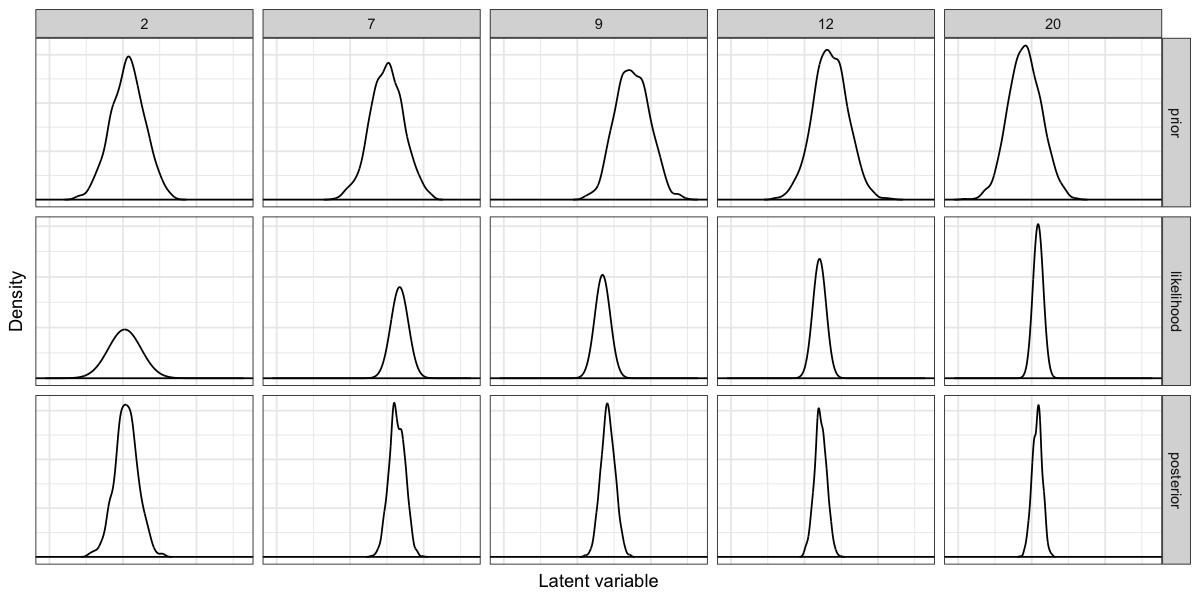

In [74]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_posterior(em_output)

## Appendix

### Derivation of posterior

![](deriv_posterior.png)

### Derivation of expected CLL

![](deriv_cll.png)